##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Overfit and underfit

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/overfit_and_underfit"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

As always, the code in this example will use the `tf.keras` API, which you can learn more about in the TensorFlow [Keras guide](https://www.tensorflow.org/guide/keras).

In both of the previous examples—[classifying text](text_classification_with_hub.ipynb) and [predicting fuel efficiency](regression.ipynb)—the accuracy of models on the validation data would peak after training for a number of epochs and then stagnate or start decreasing.

In other words, your model would *overfit* to the training data. Learning how to deal with overfitting is important. Although it's often possible to achieve high accuracy on the *training set*, what you really want is to develop models that generalize well to a *testing set* (or data they haven't seen before).

The opposite of overfitting is *underfitting*. Underfitting occurs when there is still room for improvement on the train data. This can happen for a number of reasons: If the model is not powerful enough, is over-regularized, or has simply not been trained long enough. This means the network has not learned the relevant patterns in the training data.

If you train for too long though, the model will start to overfit and learn patterns from the training data that don't generalize to the test data. You need to strike a balance. Understanding how to train for an appropriate number of epochs as you'll explore below is a useful skill.

To prevent overfitting, the best solution is to use more complete training data. The dataset should cover the full range of inputs that the model is expected to handle. Additional data may only be useful if it covers new and interesting cases.

A model trained on more complete data will naturally generalize better. When that is no longer possible, the next best solution is to use techniques like regularization. These place constraints on the quantity and type of information your model can store.  If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

In this notebook, you'll explore several common regularization techniques, and use them to improve on a classification model.

## Setup

Before getting started, import the necessary packages:

In [3]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.9.1


In [4]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmpfs/tmp/pip-req-build-wix5ogpu
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmpfs/tmp/pip-req-build-wix5ogpu


  Resolved https://github.com/tensorflow/docs to commit 93a59315fbbc794d970957e058d6738d31086f76


  Preparing metadata (setup.py) ... -

 \

 |

 /

 done


  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)


  Using cached PyYAML-6.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (596 kB)


 \

 |

 /

 -

 \

 |

 done


  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=175810 sha256=3c1c1dfcbf6801d3f4bfde42e17679649ecfc8d4e9ffd5fd58a15335999f7e9a
  Stored in directory: /tmpfs/tmp/pip-ephem-wheel-cache-5t7owdl9/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [5]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile


In [6]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## The Higgs dataset

The goal of this tutorial is not to do particle physics, so don't dwell on the details of the dataset. It contains 11,000,000 examples, each with 28 features, and a binary class label.

In [7]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

      8192/2816407858 [..............................] - ETA: 2s

     16384/2816407858 [..............................] - ETA: 2:34:09

     49152/2816407858 [..............................] - ETA: 1:46:32

     90112/2816407858 [..............................] - ETA: 1:33:53

    196608/2816407858 [..............................] - ETA: 55:04  

    589824/2816407858 [..............................] - ETA: 22:20

   1204224/2816407858 [..............................] - ETA: 12:53

   2162688/2816407858 [..............................] - ETA: 8:15 

   3809280/2816407858 [..............................] - ETA: 5:18

   7020544/2816407858 [..............................] - ETA: 3:12

  10223616/2816407858 [..............................] - ETA: 2:25

  13385728/2816407858 [..............................] - ETA: 2:02

  16547840/2816407858 [..............................] - ETA: 1:47

  19685376/2816407858 [..............................] - ETA: 1:37

  22831104/2816407858 [..............................] - ETA: 1:30

  25976832/2816407858 [..............................] - ETA: 1:25

  29122560/2816407858 [..............................] - ETA: 1:20

  32309248/2816407858 [..............................] - ETA: 1:16

  35504128/2816407858 [..............................] - ETA: 1:13

  38707200/2816407858 [..............................] - ETA: 1:11

  41926656/2816407858 [..............................] - ETA: 1:09

  45137920/2816407858 [..............................] - ETA: 1:07

  48340992/2816407858 [..............................] - ETA: 1:05

  51527680/2816407858 [..............................] - ETA: 1:04

  54697984/2816407858 [..............................] - ETA: 1:02

  57868288/2816407858 [..............................] - ETA: 1:01

  61030400/2816407858 [..............................] - ETA: 1:00

  64249856/2816407858 [..............................] - ETA: 59s 

  67125248/2816407858 [..............................] - ETA: 59s

  70328320/2816407858 [..............................] - ETA: 58s

  73547776/2816407858 [..............................] - ETA: 57s

  76677120/2816407858 [..............................] - ETA: 57s

  79642624/2816407858 [..............................] - ETA: 56s

  82812928/2816407858 [..............................] - ETA: 56s

  85966848/2816407858 [..............................] - ETA: 55s

  89210880/2816407858 [..............................] - ETA: 55s

  92364800/2816407858 [..............................] - ETA: 54s

  95338496/2816407858 [>.............................] - ETA: 54s

  98287616/2816407858 [>.............................] - ETA: 54s

 101482496/2816407858 [>.............................] - ETA: 53s

 104685568/2816407858 [>.............................] - ETA: 53s

 107905024/2816407858 [>.............................] - ETA: 52s

 111067136/2816407858 [>.............................] - ETA: 52s

 114221056/2816407858 [>.............................] - ETA: 52s

 117161984/2816407858 [>.............................] - ETA: 52s

 120168448/2816407858 [>.............................] - ETA: 51s

 123412480/2816407858 [>.............................] - ETA: 51s

 126590976/2816407858 [>.............................] - ETA: 51s

 129818624/2816407858 [>.............................] - ETA: 50s

 133029888/2816407858 [>.............................] - ETA: 50s

 136200192/2816407858 [>.............................] - ETA: 50s

 139386880/2816407858 [>.............................] - ETA: 50s

 142295040/2816407858 [>.............................] - ETA: 50s

 145465344/2816407858 [>.............................] - ETA: 49s

 148652032/2816407858 [>.............................] - ETA: 49s

 151846912/2816407858 [>.............................] - ETA: 49s

 155074560/2816407858 [>.............................] - ETA: 49s

 158228480/2816407858 [>.............................] - ETA: 49s

 161415168/2816407858 [>.............................] - ETA: 48s

 164552704/2816407858 [>.............................] - ETA: 48s

 167731200/2816407858 [>.............................] - ETA: 48s

 170696704/2816407858 [>.............................] - ETA: 48s

 173899776/2816407858 [>.............................] - ETA: 48s

 177053696/2816407858 [>.............................] - ETA: 47s

 180264960/2816407858 [>.............................] - ETA: 47s

 183435264/2816407858 [>.............................] - ETA: 47s

 186630144/2816407858 [>.............................] - ETA: 47s

 189784064/2816407858 [=>............................] - ETA: 47s

 192970752/2816407858 [=>............................] - ETA: 47s

 196116480/2816407858 [=>............................] - ETA: 47s

 199237632/2816407858 [=>............................] - ETA: 46s

 202432512/2816407858 [=>............................] - ETA: 46s

 205479936/2816407858 [=>............................] - ETA: 46s

 208683008/2816407858 [=>............................] - ETA: 46s

 211722240/2816407858 [=>............................] - ETA: 46s

 214925312/2816407858 [=>............................] - ETA: 46s

 217997312/2816407858 [=>............................] - ETA: 46s

 221224960/2816407858 [=>............................] - ETA: 46s

 224174080/2816407858 [=>............................] - ETA: 46s

 227287040/2816407858 [=>............................] - ETA: 45s

 230449152/2816407858 [=>............................] - ETA: 45s

 233578496/2816407858 [=>............................] - ETA: 45s

 236724224/2816407858 [=>............................] - ETA: 45s

 239886336/2816407858 [=>............................] - ETA: 45s

 243064832/2816407858 [=>............................] - ETA: 45s

 245972992/2816407858 [=>............................] - ETA: 45s

 249192448/2816407858 [=>............................] - ETA: 45s

 252387328/2816407858 [=>............................] - ETA: 45s

 255574016/2816407858 [=>............................] - ETA: 45s

 258703360/2816407858 [=>............................] - ETA: 44s

 261922816/2816407858 [=>............................] - ETA: 44s

 265117696/2816407858 [=>............................] - ETA: 44s

 268288000/2816407858 [=>............................] - ETA: 44s

 271482880/2816407858 [=>............................] - ETA: 44s

 274685952/2816407858 [=>............................] - ETA: 44s

 277889024/2816407858 [=>............................] - ETA: 44s

 280903680/2816407858 [=>............................] - ETA: 44s

 284057600/2816407858 [==>...........................] - ETA: 44s

 287170560/2816407858 [==>...........................] - ETA: 43s

 290111488/2816407858 [==>...........................] - ETA: 43s

 292593664/2816407858 [==>...........................] - ETA: 43s

 295657472/2816407858 [==>...........................] - ETA: 43s

 298795008/2816407858 [==>...........................] - ETA: 43s

 302030848/2816407858 [==>...........................] - ETA: 43s

 305209344/2816407858 [==>...........................] - ETA: 43s

 308396032/2816407858 [==>...........................] - ETA: 43s

 311574528/2816407858 [==>...........................] - ETA: 43s

 314793984/2816407858 [==>...........................] - ETA: 43s

 317964288/2816407858 [==>...........................] - ETA: 43s

 321150976/2816407858 [==>...........................] - ETA: 43s

 324321280/2816407858 [==>...........................] - ETA: 43s

 327524352/2816407858 [==>...........................] - ETA: 42s

 330735616/2816407858 [==>...........................] - ETA: 42s

 333922304/2816407858 [==>...........................] - ETA: 42s

 336953344/2816407858 [==>...........................] - ETA: 42s

 339771392/2816407858 [==>...........................] - ETA: 42s

 342827008/2816407858 [==>...........................] - ETA: 42s

 345784320/2816407858 [==>...........................] - ETA: 42s

 348733440/2816407858 [==>...........................] - ETA: 42s

 351739904/2816407858 [==>...........................] - ETA: 42s

 354893824/2816407858 [==>...........................] - ETA: 42s

 358080512/2816407858 [==>...........................] - ETA: 42s

 361267200/2816407858 [==>...........................] - ETA: 42s

 364445696/2816407858 [==>...........................] - ETA: 42s

 367616000/2816407858 [==>...........................] - ETA: 41s

 370802688/2816407858 [==>...........................] - ETA: 41s

 373972992/2816407858 [==>...........................] - ETA: 41s

 377167872/2816407858 [===>..........................] - ETA: 41s

 380387328/2816407858 [===>..........................] - ETA: 41s

 383549440/2816407858 [===>..........................] - ETA: 41s

 386727936/2816407858 [===>..........................] - ETA: 41s

 389906432/2816407858 [===>..........................] - ETA: 41s

 393060352/2816407858 [===>..........................] - ETA: 41s

 396206080/2816407858 [===>..........................] - ETA: 41s

 399351808/2816407858 [===>..........................] - ETA: 41s

 402505728/2816407858 [===>..........................] - ETA: 41s

 405430272/2816407858 [===>..........................] - ETA: 41s

 408387584/2816407858 [===>..........................] - ETA: 41s

 411394048/2816407858 [===>..........................] - ETA: 40s

 414343168/2816407858 [===>..........................] - ETA: 40s

 417300480/2816407858 [===>..........................] - ETA: 40s

 420487168/2816407858 [===>..........................] - ETA: 40s

 423657472/2816407858 [===>..........................] - ETA: 40s

 426835968/2816407858 [===>..........................] - ETA: 40s

 430006272/2816407858 [===>..........................] - ETA: 40s

 433184768/2816407858 [===>..........................] - ETA: 40s

 436363264/2816407858 [===>..........................] - ETA: 40s

 439549952/2816407858 [===>..........................] - ETA: 40s

 442703872/2816407858 [===>..........................] - ETA: 40s

 445849600/2816407858 [===>..........................] - ETA: 40s

 449052672/2816407858 [===>..........................] - ETA: 40s

 452231168/2816407858 [===>..........................] - ETA: 40s

 455442432/2816407858 [===>..........................] - ETA: 39s

 458629120/2816407858 [===>..........................] - ETA: 39s

 461766656/2816407858 [===>..........................] - ETA: 39s

 464723968/2816407858 [===>..........................] - ETA: 39s

 467615744/2816407858 [===>..........................] - ETA: 39s

 470499328/2816407858 [====>.........................] - ETA: 39s

 473513984/2816407858 [====>.........................] - ETA: 39s

 476495872/2816407858 [====>.........................] - ETA: 39s

 479682560/2816407858 [====>.........................] - ETA: 39s

 482836480/2816407858 [====>.........................] - ETA: 39s

 485998592/2816407858 [====>.........................] - ETA: 39s

 489160704/2816407858 [====>.........................] - ETA: 39s

 492355584/2816407858 [====>.........................] - ETA: 39s

 495534080/2816407858 [====>.........................] - ETA: 39s

 498737152/2816407858 [====>.........................] - ETA: 39s

 501923840/2816407858 [====>.........................] - ETA: 39s

 505118720/2816407858 [====>.........................] - ETA: 38s

 508313600/2816407858 [====>.........................] - ETA: 38s

 511500288/2816407858 [====>.........................] - ETA: 38s

 514670592/2816407858 [====>.........................] - ETA: 38s

 517865472/2816407858 [====>.........................] - ETA: 38s

 521027584/2816407858 [====>.........................] - ETA: 38s

 523894784/2816407858 [====>.........................] - ETA: 38s

 526827520/2816407858 [====>.........................] - ETA: 38s

 529776640/2816407858 [====>.........................] - ETA: 38s

 532709376/2816407858 [====>.........................] - ETA: 38s

 535805952/2816407858 [====>.........................] - ETA: 38s

 538894336/2816407858 [====>.........................] - ETA: 38s

 542089216/2816407858 [====>.........................] - ETA: 38s

 545259520/2816407858 [====>.........................] - ETA: 38s

 548413440/2816407858 [====>.........................] - ETA: 38s

 551616512/2816407858 [====>.........................] - ETA: 38s

 554811392/2816407858 [====>.........................] - ETA: 38s

 557998080/2816407858 [====>.........................] - ETA: 37s

 561160192/2816407858 [====>.........................] - ETA: 37s

 564363264/2816407858 [=====>........................] - ETA: 37s

 567558144/2816407858 [=====>........................] - ETA: 37s

 570736640/2816407858 [=====>........................] - ETA: 37s

 573923328/2816407858 [=====>........................] - ETA: 37s

 576847872/2816407858 [=====>........................] - ETA: 37s

 580026368/2816407858 [=====>........................] - ETA: 37s

 583180288/2816407858 [=====>........................] - ETA: 37s

 586178560/2816407858 [=====>........................] - ETA: 37s

 589111296/2816407858 [=====>........................] - ETA: 37s

 592068608/2816407858 [=====>........................] - ETA: 37s

 594993152/2816407858 [=====>........................] - ETA: 37s

 598179840/2816407858 [=====>........................] - ETA: 37s

 601333760/2816407858 [=====>........................] - ETA: 37s

 604512256/2816407858 [=====>........................] - ETA: 37s

 607698944/2816407858 [=====>........................] - ETA: 36s

 610861056/2816407858 [=====>........................] - ETA: 36s

 614039552/2816407858 [=====>........................] - ETA: 36s

 617201664/2816407858 [=====>........................] - ETA: 36s

 620371968/2816407858 [=====>........................] - ETA: 36s

 623550464/2816407858 [=====>........................] - ETA: 36s

 626745344/2816407858 [=====>........................] - ETA: 36s

 629956608/2816407858 [=====>........................] - ETA: 36s

 633110528/2816407858 [=====>........................] - ETA: 36s

 636321792/2816407858 [=====>........................] - ETA: 36s

 639508480/2816407858 [=====>........................] - ETA: 36s

 642686976/2816407858 [=====>........................] - ETA: 36s

 645808128/2816407858 [=====>........................] - ETA: 36s

 648486912/2816407858 [=====>........................] - ETA: 36s

 651444224/2816407858 [=====>........................] - ETA: 36s

 654368768/2816407858 [=====>........................] - ETA: 36s

 657301504/2816407858 [======>.......................] - ETA: 36s

 660471808/2816407858 [======>.......................] - ETA: 36s

 663642112/2816407858 [======>.......................] - ETA: 35s

 666861568/2816407858 [======>.......................] - ETA: 35s

 670040064/2816407858 [======>.......................] - ETA: 35s

 673210368/2816407858 [======>.......................] - ETA: 35s

 676347904/2816407858 [======>.......................] - ETA: 35s

 679550976/2816407858 [======>.......................] - ETA: 35s

 682680320/2816407858 [======>.......................] - ETA: 35s

 685891584/2816407858 [======>.......................] - ETA: 35s

 689045504/2816407858 [======>.......................] - ETA: 35s

 692248576/2816407858 [======>.......................] - ETA: 35s

 695427072/2816407858 [======>.......................] - ETA: 35s

 698597376/2816407858 [======>.......................] - ETA: 35s

 701612032/2816407858 [======>.......................] - ETA: 35s

 704536576/2816407858 [======>.......................] - ETA: 35s

 707543040/2816407858 [======>.......................] - ETA: 35s

 710475776/2816407858 [======>.......................] - ETA: 35s

 713433088/2816407858 [======>.......................] - ETA: 35s

 716341248/2816407858 [======>.......................] - ETA: 34s

 719486976/2816407858 [======>.......................] - ETA: 34s

 722649088/2816407858 [======>.......................] - ETA: 34s

 725811200/2816407858 [======>.......................] - ETA: 34s

 728981504/2816407858 [======>.......................] - ETA: 34s

 732160000/2816407858 [======>.......................] - ETA: 34s

 735289344/2816407858 [======>.......................] - ETA: 34s

 738467840/2816407858 [======>.......................] - ETA: 34s

 741597184/2816407858 [======>.......................] - ETA: 34s

 744808448/2816407858 [======>.......................] - ETA: 34s

 748003328/2816407858 [======>.......................] - ETA: 34s

 751190016/2816407858 [=======>......................] - ETA: 34s

 754384896/2816407858 [=======>......................] - ETA: 34s

 757547008/2816407858 [=======>......................] - ETA: 34s

 760709120/2816407858 [=======>......................] - ETA: 34s

 763895808/2816407858 [=======>......................] - ETA: 34s

 767090688/2816407858 [=======>......................] - ETA: 34s

 770260992/2816407858 [=======>......................] - ETA: 33s

 773447680/2816407858 [=======>......................] - ETA: 33s

 776626176/2816407858 [=======>......................] - ETA: 33s

 779616256/2816407858 [=======>......................] - ETA: 33s

 782581760/2816407858 [=======>......................] - ETA: 33s

 785481728/2816407858 [=======>......................] - ETA: 33s

 788439040/2816407858 [=======>......................] - ETA: 33s

 791404544/2816407858 [=======>......................] - ETA: 33s

 794320896/2816407858 [=======>......................] - ETA: 33s

 797499392/2816407858 [=======>......................] - ETA: 33s

 800686080/2816407858 [=======>......................] - ETA: 33s

 803856384/2816407858 [=======>......................] - ETA: 33s

 807026688/2816407858 [=======>......................] - ETA: 33s

 810237952/2816407858 [=======>......................] - ETA: 33s

 813416448/2816407858 [=======>......................] - ETA: 33s

 816627712/2816407858 [=======>......................] - ETA: 33s

 819830784/2816407858 [=======>......................] - ETA: 33s

 823042048/2816407858 [=======>......................] - ETA: 33s

 826187776/2816407858 [=======>......................] - ETA: 33s

 829415424/2816407858 [=======>......................] - ETA: 32s

 832577536/2816407858 [=======>......................] - ETA: 32s

 835715072/2816407858 [=======>......................] - ETA: 32s

 838860800/2816407858 [=======>......................] - ETA: 32s

 841990144/2816407858 [=======>......................] - ETA: 32s

 844972032/2816407858 [========>.....................] - ETA: 32s

 847978496/2816407858 [========>.....................] - ETA: 32s

 850927616/2816407858 [========>.....................] - ETA: 32s

 853901312/2816407858 [========>.....................] - ETA: 32s

 856875008/2816407858 [========>.....................] - ETA: 32s

 859840512/2816407858 [========>.....................] - ETA: 32s

 863019008/2816407858 [========>.....................] - ETA: 32s

 866131968/2816407858 [========>.....................] - ETA: 32s

 869335040/2816407858 [========>.....................] - ETA: 32s

 872529920/2816407858 [========>.....................] - ETA: 32s

 875634688/2816407858 [========>.....................] - ETA: 32s

 878796800/2816407858 [========>.....................] - ETA: 32s

 881975296/2816407858 [========>.....................] - ETA: 32s

 885186560/2816407858 [========>.....................] - ETA: 31s

 888381440/2816407858 [========>.....................] - ETA: 31s

 891568128/2816407858 [========>.....................] - ETA: 31s

 894754816/2816407858 [========>.....................] - ETA: 31s

 897941504/2816407858 [========>.....................] - ETA: 31s

 901120000/2816407858 [========>.....................] - ETA: 31s

 904314880/2816407858 [========>.....................] - ETA: 31s

 907395072/2816407858 [========>.....................] - ETA: 31s

 910352384/2816407858 [========>.....................] - ETA: 31s

 913375232/2816407858 [========>.....................] - ETA: 31s

 916307968/2816407858 [========>.....................] - ETA: 31s

 919273472/2816407858 [========>.....................] - ETA: 31s

 922238976/2816407858 [========>.....................] - ETA: 31s

 925188096/2816407858 [========>.....................] - ETA: 31s

 928358400/2816407858 [========>.....................] - ETA: 31s

 931545088/2816407858 [========>.....................] - ETA: 31s

 934666240/2816407858 [========>.....................] - ETA: 31s

 937877504/2816407858 [========>.....................] - ETA: 31s

 941088768/2816407858 [=========>....................] - ETA: 31s

 944283648/2816407858 [=========>....................] - ETA: 30s

 947453952/2816407858 [=========>....................] - ETA: 30s

 950648832/2816407858 [=========>....................] - ETA: 30s

 953843712/2816407858 [=========>....................] - ETA: 30s

 957022208/2816407858 [=========>....................] - ETA: 30s

 960184320/2816407858 [=========>....................] - ETA: 30s

 963371008/2816407858 [=========>....................] - ETA: 30s

 966557696/2816407858 [=========>....................] - ETA: 30s

 969728000/2816407858 [=========>....................] - ETA: 30s

 972906496/2816407858 [=========>....................] - ETA: 30s

 976076800/2816407858 [=========>....................] - ETA: 30s

 979255296/2816407858 [=========>....................] - ETA: 30s

 982425600/2816407858 [=========>....................] - ETA: 30s

 985464832/2816407858 [=========>....................] - ETA: 30s

 988397568/2816407858 [=========>....................] - ETA: 30s

 991592448/2816407858 [=========>....................] - ETA: 30s

 994648064/2816407858 [=========>....................] - ETA: 30s

 997621760/2816407858 [=========>....................] - ETA: 30s

1000579072/2816407858 [=========>....................] - ETA: 29s

1003552768/2816407858 [=========>....................] - ETA: 29s

1006485504/2816407858 [=========>....................] - ETA: 29s

1009598464/2816407858 [=========>....................] - ETA: 29s

1012776960/2816407858 [=========>....................] - ETA: 29s

1015980032/2816407858 [=========>....................] - ETA: 29s

1019142144/2816407858 [=========>....................] - ETA: 29s

1022328832/2816407858 [=========>....................] - ETA: 29s

1025531904/2816407858 [=========>....................] - ETA: 29s

1028743168/2816407858 [=========>....................] - ETA: 29s

1031938048/2816407858 [=========>....................] - ETA: 29s

1035141120/2816407858 [==========>...................] - ETA: 29s

1038303232/2816407858 [==========>...................] - ETA: 29s

1041448960/2816407858 [==========>...................] - ETA: 29s

1044578304/2816407858 [==========>...................] - ETA: 29s

1047732224/2816407858 [==========>...................] - ETA: 29s

1050869760/2816407858 [==========>...................] - ETA: 29s

1053859840/2816407858 [==========>...................] - ETA: 29s

1056800768/2816407858 [==========>...................] - ETA: 29s

1059758080/2816407858 [==========>...................] - ETA: 28s

1062723584/2816407858 [==========>...................] - ETA: 28s

1065705472/2816407858 [==========>...................] - ETA: 28s

1068670976/2816407858 [==========>...................] - ETA: 28s

1071734784/2816407858 [==========>...................] - ETA: 28s

1074888704/2816407858 [==========>...................] - ETA: 28s

1078034432/2816407858 [==========>...................] - ETA: 28s

1081204736/2816407858 [==========>...................] - ETA: 28s

1084358656/2816407858 [==========>...................] - ETA: 28s

1087561728/2816407858 [==========>...................] - ETA: 28s

1090748416/2816407858 [==========>...................] - ETA: 28s

1093959680/2816407858 [==========>...................] - ETA: 28s

1097138176/2816407858 [==========>...................] - ETA: 28s

1100275712/2816407858 [==========>...................] - ETA: 28s

1103413248/2816407858 [==========>...................] - ETA: 28s

1106624512/2816407858 [==========>...................] - ETA: 28s

1109811200/2816407858 [==========>...................] - ETA: 28s

1112956928/2816407858 [==========>...................] - ETA: 28s

1116102656/2816407858 [==========>...................] - ETA: 27s

1119272960/2816407858 [==========>...................] - ETA: 27s

1122451456/2816407858 [==========>...................] - ETA: 27s

1125466112/2816407858 [==========>...................] - ETA: 27s

1128652800/2816407858 [===========>..................] - ETA: 27s

1131724800/2816407858 [===========>..................] - ETA: 27s

1134690304/2816407858 [===========>..................] - ETA: 27s

1137664000/2816407858 [===========>..................] - ETA: 27s

1140637696/2816407858 [===========>..................] - ETA: 27s

1143611392/2816407858 [===========>..................] - ETA: 27s

1146413056/2816407858 [===========>..................] - ETA: 27s

1149648896/2816407858 [===========>..................] - ETA: 27s

1152851968/2816407858 [===========>..................] - ETA: 27s

1156063232/2816407858 [===========>..................] - ETA: 27s

1159266304/2816407858 [===========>..................] - ETA: 27s

1162444800/2816407858 [===========>..................] - ETA: 27s

1165647872/2816407858 [===========>..................] - ETA: 27s

1168875520/2816407858 [===========>..................] - ETA: 27s

1172086784/2816407858 [===========>..................] - ETA: 27s

1175265280/2816407858 [===========>..................] - ETA: 26s

1178435584/2816407858 [===========>..................] - ETA: 26s

1181581312/2816407858 [===========>..................] - ETA: 26s

1184776192/2816407858 [===========>..................] - ETA: 26s

1187938304/2816407858 [===========>..................] - ETA: 26s

1191141376/2816407858 [===========>..................] - ETA: 26s

1194319872/2816407858 [===========>..................] - ETA: 26s

1197481984/2816407858 [===========>..................] - ETA: 26s

1200553984/2816407858 [===========>..................] - ETA: 26s

1203519488/2816407858 [===========>..................] - ETA: 26s

1206525952/2816407858 [===========>..................] - ETA: 26s

1209491456/2816407858 [===========>..................] - ETA: 26s

1212440576/2816407858 [===========>..................] - ETA: 26s

1215594496/2816407858 [===========>..................] - ETA: 26s

1218781184/2816407858 [===========>..................] - ETA: 26s

1221951488/2816407858 [============>.................] - ETA: 26s

1225146368/2816407858 [============>.................] - ETA: 26s

1228242944/2816407858 [============>.................] - ETA: 26s

1231446016/2816407858 [============>.................] - ETA: 26s

1234583552/2816407858 [============>.................] - ETA: 26s

1237729280/2816407858 [============>.................] - ETA: 25s

1240907776/2816407858 [============>.................] - ETA: 25s

1244110848/2816407858 [============>.................] - ETA: 25s

1247281152/2816407858 [============>.................] - ETA: 25s

1250467840/2816407858 [============>.................] - ETA: 25s

1253670912/2816407858 [============>.................] - ETA: 25s

1256824832/2816407858 [============>.................] - ETA: 25s

1259986944/2816407858 [============>.................] - ETA: 25s

1263149056/2816407858 [============>.................] - ETA: 25s

1266188288/2816407858 [============>.................] - ETA: 25s

1269153792/2816407858 [============>.................] - ETA: 25s

1272086528/2816407858 [============>.................] - ETA: 25s

1275084800/2816407858 [============>.................] - ETA: 25s

1278058496/2816407858 [============>.................] - ETA: 25s

1281007616/2816407858 [============>.................] - ETA: 25s

1284112384/2816407858 [============>.................] - ETA: 25s

1287282688/2816407858 [============>.................] - ETA: 25s

1290461184/2816407858 [============>.................] - ETA: 25s

1293606912/2816407858 [============>.................] - ETA: 25s

1296752640/2816407858 [============>.................] - ETA: 24s

1299922944/2816407858 [============>.................] - ETA: 24s

1303126016/2816407858 [============>.................] - ETA: 24s

1306304512/2816407858 [============>.................] - ETA: 24s

1309507584/2816407858 [============>.................] - ETA: 24s

1312702464/2816407858 [============>.................] - ETA: 24s

1315897344/2816407858 [=============>................] - ETA: 24s

1319067648/2816407858 [=============>................] - ETA: 24s

1322254336/2816407858 [=============>................] - ETA: 24s

1325449216/2816407858 [=============>................] - ETA: 24s

1328578560/2816407858 [=============>................] - ETA: 24s

1331765248/2816407858 [=============>................] - ETA: 24s

1334960128/2816407858 [=============>................] - ETA: 24s

1338056704/2816407858 [=============>................] - ETA: 24s

1340997632/2816407858 [=============>................] - ETA: 24s

1344004096/2816407858 [=============>................] - ETA: 24s

1346904064/2816407858 [=============>................] - ETA: 24s

1349869568/2816407858 [=============>................] - ETA: 24s

1352843264/2816407858 [=============>................] - ETA: 24s

1355866112/2816407858 [=============>................] - ETA: 23s

1359044608/2816407858 [=============>................] - ETA: 23s

1362190336/2816407858 [=============>................] - ETA: 23s

1365319680/2816407858 [=============>................] - ETA: 23s

1368530944/2816407858 [=============>................] - ETA: 23s

1371660288/2816407858 [=============>................] - ETA: 23s

1374887936/2816407858 [=============>................] - ETA: 23s

1378082816/2816407858 [=============>................] - ETA: 23s

1381253120/2816407858 [=============>................] - ETA: 23s

1384415232/2816407858 [=============>................] - ETA: 23s

1387610112/2816407858 [=============>................] - ETA: 23s

1390804992/2816407858 [=============>................] - ETA: 23s

1394008064/2816407858 [=============>................] - ETA: 23s

1397211136/2816407858 [=============>................] - ETA: 23s

1400381440/2816407858 [=============>................] - ETA: 23s

1403543552/2816407858 [=============>................] - ETA: 23s

1406697472/2816407858 [=============>................] - ETA: 23s

1409835008/2816407858 [==============>...............] - ETA: 23s

1412956160/2816407858 [==============>...............] - ETA: 23s

1415938048/2816407858 [==============>...............] - ETA: 22s

1418829824/2816407858 [==============>...............] - ETA: 22s

1421828096/2816407858 [==============>...............] - ETA: 22s

1424785408/2816407858 [==============>...............] - ETA: 22s

1427750912/2816407858 [==============>...............] - ETA: 22s

1430708224/2816407858 [==============>...............] - ETA: 22s

1433780224/2816407858 [==============>...............] - ETA: 22s

1436942336/2816407858 [==============>...............] - ETA: 22s

1440137216/2816407858 [==============>...............] - ETA: 22s

1443258368/2816407858 [==============>...............] - ETA: 22s

1446453248/2816407858 [==============>...............] - ETA: 22s

1449631744/2816407858 [==============>...............] - ETA: 22s

1452744704/2816407858 [==============>...............] - ETA: 22s

1455947776/2816407858 [==============>...............] - ETA: 22s

1459167232/2816407858 [==============>...............] - ETA: 22s

1462329344/2816407858 [==============>...............] - ETA: 22s

1465507840/2816407858 [==============>...............] - ETA: 22s

1468719104/2816407858 [==============>...............] - ETA: 22s

1471922176/2816407858 [==============>...............] - ETA: 22s

1475125248/2816407858 [==============>...............] - ETA: 21s

1478361088/2816407858 [==============>...............] - ETA: 21s

1481506816/2816407858 [==============>...............] - ETA: 21s

1484570624/2816407858 [==============>...............] - ETA: 21s

1487101952/2816407858 [==============>...............] - ETA: 21s

1490100224/2816407858 [==============>...............] - ETA: 21s

1493032960/2816407858 [==============>...............] - ETA: 21s

1496023040/2816407858 [==============>...............] - ETA: 21s

1498996736/2816407858 [==============>...............] - ETA: 21s

1502150656/2816407858 [===============>..............] - ETA: 21s

1505353728/2816407858 [===============>..............] - ETA: 21s

1508524032/2816407858 [===============>..............] - ETA: 21s

1511694336/2816407858 [===============>..............] - ETA: 21s

1514823680/2816407858 [===============>..............] - ETA: 21s

1518043136/2816407858 [===============>..............] - ETA: 21s

1521180672/2816407858 [===============>..............] - ETA: 21s

1524400128/2816407858 [===============>..............] - ETA: 21s

1527603200/2816407858 [===============>..............] - ETA: 21s

1530773504/2816407858 [===============>..............] - ETA: 21s

1533976576/2816407858 [===============>..............] - ETA: 21s

1537146880/2816407858 [===============>..............] - ETA: 20s

1540317184/2816407858 [===============>..............] - ETA: 20s

1543520256/2816407858 [===============>..............] - ETA: 20s

1546698752/2816407858 [===============>..............] - ETA: 20s

1549877248/2816407858 [===============>..............] - ETA: 20s

1553063936/2816407858 [===============>..............] - ETA: 20s

1556201472/2816407858 [===============>..............] - ETA: 20s

1559396352/2816407858 [===============>..............] - ETA: 20s

1562591232/2816407858 [===============>..............] - ETA: 20s

1565728768/2816407858 [===============>..............] - ETA: 20s

1568694272/2816407858 [===============>..............] - ETA: 20s

1571643392/2816407858 [===============>..............] - ETA: 20s

1574649856/2816407858 [===============>..............] - ETA: 20s

1577598976/2816407858 [===============>..............] - ETA: 20s

1580589056/2816407858 [===============>..............] - ETA: 20s

1583431680/2816407858 [===============>..............] - ETA: 20s

1586626560/2816407858 [===============>..............] - ETA: 20s

1589764096/2816407858 [===============>..............] - ETA: 20s

1592958976/2816407858 [===============>..............] - ETA: 20s

1596121088/2816407858 [================>.............] - ETA: 19s

1599356928/2816407858 [================>.............] - ETA: 19s

1602469888/2816407858 [================>.............] - ETA: 19s

1605705728/2816407858 [================>.............] - ETA: 19s

1608859648/2816407858 [================>.............] - ETA: 19s

1612087296/2816407858 [================>.............] - ETA: 19s

1615257600/2816407858 [================>.............] - ETA: 19s

1618403328/2816407858 [================>.............] - ETA: 19s

1621606400/2816407858 [================>.............] - ETA: 19s

1624801280/2816407858 [================>.............] - ETA: 19s

1627996160/2816407858 [================>.............] - ETA: 19s

1631182848/2816407858 [================>.............] - ETA: 19s

1634279424/2816407858 [================>.............] - ETA: 19s

1637277696/2816407858 [================>.............] - ETA: 19s

1640185856/2816407858 [================>.............] - ETA: 19s

1643192320/2816407858 [================>.............] - ETA: 19s

1646125056/2816407858 [================>.............] - ETA: 19s

1649082368/2816407858 [================>.............] - ETA: 19s

1652252672/2816407858 [================>.............] - ETA: 19s

1655382016/2816407858 [================>.............] - ETA: 19s

1658535936/2816407858 [================>.............] - ETA: 18s

1661689856/2816407858 [================>.............] - ETA: 18s

1664868352/2816407858 [================>.............] - ETA: 18s

1668063232/2816407858 [================>.............] - ETA: 18s

1671266304/2816407858 [================>.............] - ETA: 18s

1674444800/2816407858 [================>.............] - ETA: 18s

1677606912/2816407858 [================>.............] - ETA: 18s

1680793600/2816407858 [================>.............] - ETA: 18s

1683972096/2816407858 [================>.............] - ETA: 18s

1687150592/2816407858 [================>.............] - ETA: 18s

1690329088/2816407858 [=================>............] - ETA: 18s

1693523968/2816407858 [=================>............] - ETA: 18s

1696669696/2816407858 [=================>............] - ETA: 18s

1699823616/2816407858 [=================>............] - ETA: 18s

1702764544/2816407858 [=================>............] - ETA: 18s

1705721856/2816407858 [=================>............] - ETA: 18s

1708662784/2816407858 [=================>............] - ETA: 18s

1711611904/2816407858 [=================>............] - ETA: 18s

1714561024/2816407858 [=================>............] - ETA: 18s

1717714944/2816407858 [=================>............] - ETA: 17s

1720926208/2816407858 [=================>............] - ETA: 17s

1724022784/2816407858 [=================>............] - ETA: 17s

1727184896/2816407858 [=================>............] - ETA: 17s

1730387968/2816407858 [=================>............] - ETA: 17s

1733550080/2816407858 [=================>............] - ETA: 17s

1736720384/2816407858 [=================>............] - ETA: 17s

1739939840/2816407858 [=================>............] - ETA: 17s

1743151104/2816407858 [=================>............] - ETA: 17s

1746345984/2816407858 [=================>............] - ETA: 17s

1749549056/2816407858 [=================>............] - ETA: 17s

1752752128/2816407858 [=================>............] - ETA: 17s

1755947008/2816407858 [=================>............] - ETA: 17s

1759158272/2816407858 [=================>............] - ETA: 17s

1762336768/2816407858 [=================>............] - ETA: 17s

1765531648/2816407858 [=================>............] - ETA: 17s

1768669184/2816407858 [=================>............] - ETA: 17s

1771888640/2816407858 [=================>............] - ETA: 17s

1775009792/2816407858 [=================>............] - ETA: 17s

1778212864/2816407858 [=================>............] - ETA: 16s

1781260288/2816407858 [=================>............] - ETA: 16s

1784283136/2816407858 [==================>...........] - ETA: 16s

1787281408/2816407858 [==================>...........] - ETA: 16s

1790255104/2816407858 [==================>...........] - ETA: 16s

1793220608/2816407858 [==================>...........] - ETA: 16s

1796177920/2816407858 [==================>...........] - ETA: 16s

1799143424/2816407858 [==================>...........] - ETA: 16s

1802100736/2816407858 [==================>...........] - ETA: 16s

1805295616/2816407858 [==================>...........] - ETA: 16s

1808498688/2816407858 [==================>...........] - ETA: 16s

1811701760/2816407858 [==================>...........] - ETA: 16s

1814888448/2816407858 [==================>...........] - ETA: 16s

1818066944/2816407858 [==================>...........] - ETA: 16s

1821229056/2816407858 [==================>...........] - ETA: 16s

1824440320/2816407858 [==================>...........] - ETA: 16s

1827594240/2816407858 [==================>...........] - ETA: 16s

1830756352/2816407858 [==================>...........] - ETA: 16s

1833951232/2816407858 [==================>...........] - ETA: 16s

1837088768/2816407858 [==================>...........] - ETA: 16s

1840234496/2816407858 [==================>...........] - ETA: 15s

1843412992/2816407858 [==================>...........] - ETA: 15s

1846575104/2816407858 [==================>...........] - ETA: 15s

1849753600/2816407858 [==================>...........] - ETA: 15s

1852948480/2816407858 [==================>...........] - ETA: 15s

1856151552/2816407858 [==================>...........] - ETA: 15s

1859100672/2816407858 [==================>...........] - ETA: 15s

1862107136/2816407858 [==================>...........] - ETA: 15s

1865056256/2816407858 [==================>...........] - ETA: 15s

1868046336/2816407858 [==================>...........] - ETA: 15s

1870979072/2816407858 [==================>...........] - ETA: 15s

1873952768/2816407858 [==================>...........] - ETA: 15s

1877147648/2816407858 [==================>...........] - ETA: 15s

1880285184/2816407858 [===================>..........] - ETA: 15s

1883447296/2816407858 [===================>..........] - ETA: 15s

1886683136/2816407858 [===================>..........] - ETA: 15s

1889861632/2816407858 [===================>..........] - ETA: 15s

1893072896/2816407858 [===================>..........] - ETA: 15s

1896243200/2816407858 [===================>..........] - ETA: 15s

1899421696/2816407858 [===================>..........] - ETA: 14s

1902567424/2816407858 [===================>..........] - ETA: 14s

1905795072/2816407858 [===================>..........] - ETA: 14s

1908998144/2816407858 [===================>..........] - ETA: 14s

1912168448/2816407858 [===================>..........] - ETA: 14s

1915404288/2816407858 [===================>..........] - ETA: 14s

1918550016/2816407858 [===================>..........] - ETA: 14s

1921753088/2816407858 [===================>..........] - ETA: 14s

1924890624/2816407858 [===================>..........] - ETA: 14s

1928126464/2816407858 [===================>..........] - ETA: 14s

1931304960/2816407858 [===================>..........] - ETA: 14s

1934458880/2816407858 [===================>..........] - ETA: 14s

1937637376/2816407858 [===================>..........] - ETA: 14s

1940717568/2816407858 [===================>..........] - ETA: 14s

1943666688/2816407858 [===================>..........] - ETA: 14s

1946640384/2816407858 [===================>..........] - ETA: 14s

1949597696/2816407858 [===================>..........] - ETA: 14s

1952563200/2816407858 [===================>..........] - ETA: 14s

1955536896/2816407858 [===================>..........] - ETA: 14s

1958518784/2816407858 [===================>..........] - ETA: 14s

1961705472/2816407858 [===================>..........] - ETA: 13s

1964933120/2816407858 [===================>..........] - ETA: 13s

1968062464/2816407858 [===================>..........] - ETA: 13s

1971249152/2816407858 [===================>..........] - ETA: 13s

1974460416/2816407858 [====================>.........] - ETA: 13s

1977638912/2816407858 [====================>.........] - ETA: 13s

1980809216/2816407858 [====================>.........] - ETA: 13s

1983954944/2816407858 [====================>.........] - ETA: 13s

1987141632/2816407858 [====================>.........] - ETA: 13s

1990336512/2816407858 [====================>.........] - ETA: 13s

1993531392/2816407858 [====================>.........] - ETA: 13s

1996734464/2816407858 [====================>.........] - ETA: 13s

1999953920/2816407858 [====================>.........] - ETA: 13s

2003148800/2816407858 [====================>.........] - ETA: 13s

2006310912/2816407858 [====================>.........] - ETA: 13s

2009473024/2816407858 [====================>.........] - ETA: 13s

2012667904/2816407858 [====================>.........] - ETA: 13s

2015633408/2816407858 [====================>.........] - ETA: 13s

2018598912/2816407858 [====================>.........] - ETA: 13s

2021580800/2816407858 [====================>.........] - ETA: 12s

2024562688/2816407858 [====================>.........] - ETA: 12s

2027520000/2816407858 [====================>.........] - ETA: 12s

2030501888/2816407858 [====================>.........] - ETA: 12s

2033369088/2816407858 [====================>.........] - ETA: 12s

2036424704/2816407858 [====================>.........] - ETA: 12s

2039660544/2816407858 [====================>.........] - ETA: 12s

2042839040/2816407858 [====================>.........] - ETA: 12s

2046074880/2816407858 [====================>.........] - ETA: 12s

2049294336/2816407858 [====================>.........] - ETA: 12s

2052481024/2816407858 [====================>.........] - ETA: 12s

2055675904/2816407858 [====================>.........] - ETA: 12s

2058887168/2816407858 [====================>.........] - ETA: 12s

2062090240/2816407858 [====================>.........] - ETA: 12s

2065268736/2816407858 [====================>.........] - ETA: 12s

2068389888/2816407858 [=====================>........] - ETA: 12s

2071543808/2816407858 [=====================>........] - ETA: 12s

2074705920/2816407858 [=====================>........] - ETA: 12s

2077892608/2816407858 [=====================>........] - ETA: 12s

2081030144/2816407858 [=====================>........] - ETA: 12s

2084249600/2816407858 [=====================>........] - ETA: 11s

2087395328/2816407858 [=====================>........] - ETA: 11s

2090582016/2816407858 [=====================>........] - ETA: 11s

2093752320/2816407858 [=====================>........] - ETA: 11s

2096979968/2816407858 [=====================>........] - ETA: 11s

2100191232/2816407858 [=====================>........] - ETA: 11s

2103205888/2816407858 [=====================>........] - ETA: 11s

2106179584/2816407858 [=====================>........] - ETA: 11s

2109120512/2816407858 [=====================>........] - ETA: 11s

2112118784/2816407858 [=====================>........] - ETA: 11s

2115059712/2816407858 [=====================>........] - ETA: 11s

2118033408/2816407858 [=====================>........] - ETA: 11s

2121072640/2816407858 [=====================>........] - ETA: 11s

2124234752/2816407858 [=====================>........] - ETA: 11s

2127380480/2816407858 [=====================>........] - ETA: 11s

2130542592/2816407858 [=====================>........] - ETA: 11s

2133680128/2816407858 [=====================>........] - ETA: 11s

2136842240/2816407858 [=====================>........] - ETA: 11s

2140061696/2816407858 [=====================>........] - ETA: 11s

2143158272/2816407858 [=====================>........] - ETA: 10s

2146344960/2816407858 [=====================>........] - ETA: 10s

2149556224/2816407858 [=====================>........] - ETA: 10s

2152726528/2816407858 [=====================>........] - ETA: 10s

2155864064/2816407858 [=====================>........] - ETA: 10s

2159050752/2816407858 [=====================>........] - ETA: 10s

2162221056/2816407858 [======================>.......] - ETA: 10s

2165440512/2816407858 [======================>.......] - ETA: 10s

2168651776/2816407858 [======================>.......] - ETA: 10s

2171830272/2816407858 [======================>.......] - ETA: 10s

2174992384/2816407858 [======================>.......] - ETA: 10s

2178113536/2816407858 [======================>.......] - ETA: 10s

2180964352/2816407858 [======================>.......] - ETA: 10s

2183979008/2816407858 [======================>.......] - ETA: 10s

2186895360/2816407858 [======================>.......] - ETA: 10s

2189918208/2816407858 [======================>.......] - ETA: 10s

2192785408/2816407858 [======================>.......] - ETA: 10s

2195742720/2816407858 [======================>.......] - ETA: 10s

2198904832/2816407858 [======================>.......] - ETA: 10s

2202107904/2816407858 [======================>.......] - ETA: 10s

2205286400/2816407858 [======================>.......] - ETA: 9s 

2208423936/2816407858 [======================>.......] - ETA: 9s

2211618816/2816407858 [======================>.......] - ETA: 9s

2214797312/2816407858 [======================>.......] - ETA: 9s

2217762816/2816407858 [======================>.......] - ETA: 9s

2220900352/2816407858 [======================>.......] - ETA: 9s

2224078848/2816407858 [======================>.......] - ETA: 9s

2227249152/2816407858 [======================>.......] - ETA: 9s

2230403072/2816407858 [======================>.......] - ETA: 9s

2233606144/2816407858 [======================>.......] - ETA: 9s

2236604416/2816407858 [======================>.......] - ETA: 9s

2239799296/2816407858 [======================>.......] - ETA: 9s

2242969600/2816407858 [======================>.......] - ETA: 9s

2246156288/2816407858 [======================>.......] - ETA: 9s

2249211904/2816407858 [======================>.......] - ETA: 9s

2252161024/2816407858 [======================>.......] - ETA: 9s

2255118336/2816407858 [=======================>......] - ETA: 9s

2258264064/2816407858 [=======================>......] - ETA: 9s

2261401600/2816407858 [=======================>......] - ETA: 9s

2264604672/2816407858 [=======================>......] - ETA: 9s

2267750400/2816407858 [=======================>......] - ETA: 8s

2270937088/2816407858 [=======================>......] - ETA: 8s

2274156544/2816407858 [=======================>......] - ETA: 8s

2277367808/2816407858 [=======================>......] - ETA: 8s

2280546304/2816407858 [=======================>......] - ETA: 8s

2283741184/2816407858 [=======================>......] - ETA: 8s

2286903296/2816407858 [=======================>......] - ETA: 8s

2290089984/2816407858 [=======================>......] - ETA: 8s

2293325824/2816407858 [=======================>......] - ETA: 8s

2296504320/2816407858 [=======================>......] - ETA: 8s

2299691008/2816407858 [=======================>......] - ETA: 8s

2302869504/2816407858 [=======================>......] - ETA: 8s

2305859584/2816407858 [=======================>......] - ETA: 8s

2308792320/2816407858 [=======================>......] - ETA: 8s

2311700480/2816407858 [=======================>......] - ETA: 8s

2314641408/2816407858 [=======================>......] - ETA: 8s

2317402112/2816407858 [=======================>......] - ETA: 8s

2320596992/2816407858 [=======================>......] - ETA: 8s

2323783680/2816407858 [=======================>......] - ETA: 8s

2326953984/2816407858 [=======================>......] - ETA: 7s

2330148864/2816407858 [=======================>......] - ETA: 7s

2333343744/2816407858 [=======================>......] - ETA: 7s

2336538624/2816407858 [=======================>......] - ETA: 7s

2339725312/2816407858 [=======================>......] - ETA: 7s

2342912000/2816407858 [=======================>......] - ETA: 7s

2346115072/2816407858 [=======================>......] - ETA: 7s

2349301760/2816407858 [========================>.....] - ETA: 7s

2352365568/2816407858 [========================>.....] - ETA: 7s

2355331072/2816407858 [========================>.....] - ETA: 7s

2358304768/2816407858 [========================>.....] - ETA: 7s

2361262080/2816407858 [========================>.....] - ETA: 7s

2364227584/2816407858 [========================>.....] - ETA: 7s

2367225856/2816407858 [========================>.....] - ETA: 7s

2370371584/2816407858 [========================>.....] - ETA: 7s

2373484544/2816407858 [========================>.....] - ETA: 7s

2376646656/2816407858 [========================>.....] - ETA: 7s

2379874304/2816407858 [========================>.....] - ETA: 7s

2382995456/2816407858 [========================>.....] - ETA: 7s

2386206720/2816407858 [========================>.....] - ETA: 7s

2389377024/2816407858 [========================>.....] - ETA: 6s

2392580096/2816407858 [========================>.....] - ETA: 6s

2395783168/2816407858 [========================>.....] - ETA: 6s

2398978048/2816407858 [========================>.....] - ETA: 6s

2402181120/2816407858 [========================>.....] - ETA: 6s

2405359616/2816407858 [========================>.....] - ETA: 6s

2408570880/2816407858 [========================>.....] - ETA: 6s

2411749376/2816407858 [========================>.....] - ETA: 6s

2414919680/2816407858 [========================>.....] - ETA: 6s

2418081792/2816407858 [========================>.....] - ETA: 6s

2421080064/2816407858 [========================>.....] - ETA: 6s

2424045568/2816407858 [========================>.....] - ETA: 6s

2426978304/2816407858 [========================>.....] - ETA: 6s

2429960192/2816407858 [========================>.....] - ETA: 6s

2432917504/2816407858 [========================>.....] - ETA: 6s

2435883008/2816407858 [========================>.....] - ETA: 6s

2438864896/2816407858 [========================>.....] - ETA: 6s

2442051584/2816407858 [=========================>....] - ETA: 6s

2445213696/2816407858 [=========================>....] - ETA: 6s

2448359424/2816407858 [=========================>....] - ETA: 6s

2451570688/2816407858 [=========================>....] - ETA: 5s

2454765568/2816407858 [=========================>....] - ETA: 5s

2457960448/2816407858 [=========================>....] - ETA: 5s

2461147136/2816407858 [=========================>....] - ETA: 5s

2464342016/2816407858 [=========================>....] - ETA: 5s

2467536896/2816407858 [=========================>....] - ETA: 5s

2470772736/2816407858 [=========================>....] - ETA: 5s

2473984000/2816407858 [=========================>....] - ETA: 5s

2477162496/2816407858 [=========================>....] - ETA: 5s

2480324608/2816407858 [=========================>....] - ETA: 5s

2483519488/2816407858 [=========================>....] - ETA: 5s

2486673408/2816407858 [=========================>....] - ETA: 5s

2489892864/2816407858 [=========================>....] - ETA: 5s

2493095936/2816407858 [=========================>....] - ETA: 5s

2496225280/2816407858 [=========================>....] - ETA: 5s

2499297280/2816407858 [=========================>....] - ETA: 5s

2502246400/2816407858 [=========================>....] - ETA: 5s

2505203712/2816407858 [=========================>....] - ETA: 5s

2507890688/2816407858 [=========================>....] - ETA: 5s

2510987264/2816407858 [=========================>....] - ETA: 4s

2514173952/2816407858 [=========================>....] - ETA: 4s

2517327872/2816407858 [=========================>....] - ETA: 4s

2520498176/2816407858 [=========================>....] - ETA: 4s

2523660288/2816407858 [=========================>....] - ETA: 4s

2526871552/2816407858 [=========================>....] - ETA: 4s

2530033664/2816407858 [=========================>....] - ETA: 4s

2533228544/2816407858 [=========================>....] - ETA: 4s

2536407040/2816407858 [==========================>...] - ETA: 4s

2539593728/2816407858 [==========================>...] - ETA: 4s

2542723072/2816407858 [==========================>...] - ETA: 4s

2545901568/2816407858 [==========================>...] - ETA: 4s

2549129216/2816407858 [==========================>...] - ETA: 4s

2552283136/2816407858 [==========================>...] - ETA: 4s

2555469824/2816407858 [==========================>...] - ETA: 4s

2558689280/2816407858 [==========================>...] - ETA: 4s

2561818624/2816407858 [==========================>...] - ETA: 4s

2564726784/2816407858 [==========================>...] - ETA: 4s

2567725056/2816407858 [==========================>...] - ETA: 4s

2570690560/2816407858 [==========================>...] - ETA: 4s

2571747328/2816407858 [==========================>...] - ETA: 3s

2573426688/2816407858 [==========================>...] - ETA: 3s

2576400384/2816407858 [==========================>...] - ETA: 3s

2579578880/2816407858 [==========================>...] - ETA: 3s

2582749184/2816407858 [==========================>...] - ETA: 3s

2585927680/2816407858 [==========================>...] - ETA: 3s

2589138944/2816407858 [==========================>...] - ETA: 3s

2592317440/2816407858 [==========================>...] - ETA: 3s

2595512320/2816407858 [==========================>...] - ETA: 3s

2598649856/2816407858 [==========================>...] - ETA: 3s

2601861120/2816407858 [==========================>...] - ETA: 3s

2605006848/2816407858 [==========================>...] - ETA: 3s

2608193536/2816407858 [==========================>...] - ETA: 3s

2611421184/2816407858 [==========================>...] - ETA: 3s

2614591488/2816407858 [==========================>...] - ETA: 3s

2617786368/2816407858 [==========================>...] - ETA: 3s

2620973056/2816407858 [==========================>...] - ETA: 3s

2624143360/2816407858 [==========================>...] - ETA: 3s

2627321856/2816407858 [==========================>...] - ETA: 3s

2630516736/2816407858 [===========================>..] - ETA: 3s

2633728000/2816407858 [===========================>..] - ETA: 2s

2636947456/2816407858 [===========================>..] - ETA: 2s

2639937536/2816407858 [===========================>..] - ETA: 2s

2642886656/2816407858 [===========================>..] - ETA: 2s

2645835776/2816407858 [===========================>..] - ETA: 2s

2648768512/2816407858 [===========================>..] - ETA: 2s

2651750400/2816407858 [===========================>..] - ETA: 2s

2654707712/2816407858 [===========================>..] - ETA: 2s

2657878016/2816407858 [===========================>..] - ETA: 2s

2660974592/2816407858 [===========================>..] - ETA: 2s

2664161280/2816407858 [===========================>..] - ETA: 2s

2667307008/2816407858 [===========================>..] - ETA: 2s

2670477312/2816407858 [===========================>..] - ETA: 2s

2673639424/2816407858 [===========================>..] - ETA: 2s

2676858880/2816407858 [===========================>..] - ETA: 2s

2680045568/2816407858 [===========================>..] - ETA: 2s

2683256832/2816407858 [===========================>..] - ETA: 2s

2686476288/2816407858 [===========================>..] - ETA: 2s

2689687552/2816407858 [===========================>..] - ETA: 2s

2692866048/2816407858 [===========================>..] - ETA: 2s

2696077312/2816407858 [===========================>..] - ETA: 1s

2699264000/2816407858 [===========================>..] - ETA: 1s

2702426112/2816407858 [===========================>..] - ETA: 1s

2705604608/2816407858 [===========================>..] - ETA: 1s

2708799488/2816407858 [===========================>..] - ETA: 1s

2711945216/2816407858 [===========================>..] - ETA: 1s

2715107328/2816407858 [===========================>..] - ETA: 1s

2718121984/2816407858 [===========================>..] - ETA: 1s

2721087488/2816407858 [===========================>..] - ETA: 1s

2724110336/2816407858 [============================>.] - ETA: 1s

2727075840/2816407858 [============================>.] - ETA: 1s

2730033152/2816407858 [============================>.] - ETA: 1s

2733006848/2816407858 [============================>.] - ETA: 1s

2735939584/2816407858 [============================>.] - ETA: 1s

2739142656/2816407858 [============================>.] - ETA: 1s

2742337536/2816407858 [============================>.] - ETA: 1s

2745524224/2816407858 [============================>.] - ETA: 1s

2748645376/2816407858 [============================>.] - ETA: 1s

2751840256/2816407858 [============================>.] - ETA: 1s

2755035136/2816407858 [============================>.] - ETA: 1s

2755764224/2816407858 [============================>.] - ETA: 0s

2759737344/2816407858 [============================>.] - ETA: 0s

2762719232/2816407858 [============================>.] - ETA: 0s

2765668352/2816407858 [============================>.] - ETA: 0s

2768764928/2816407858 [============================>.] - ETA: 0s

2771910656/2816407858 [============================>.] - ETA: 0s

2775056384/2816407858 [============================>.] - ETA: 0s

2778177536/2816407858 [============================>.] - ETA: 0s

2781339648/2816407858 [============================>.] - ETA: 0s

2784485376/2816407858 [============================>.] - ETA: 0s

2787663872/2816407858 [============================>.] - ETA: 0s

2790866944/2816407858 [============================>.] - ETA: 0s

2794086400/2816407858 [============================>.] - ETA: 0s

2797248512/2816407858 [============================>.] - ETA: 0s

2800435200/2816407858 [============================>.] - ETA: 0s

2803638272/2816407858 [============================>.] - ETA: 0s

2806833152/2816407858 [============================>.] - ETA: 0s

2810019840/2816407858 [============================>.] - ETA: 0s

2813190144/2816407858 [============================>.] - ETA: 0s

2816401408/2816407858 [============================>.] - ETA: 0s

2816407858/2816407858 [==============================] - 46s 0us/step


In [8]:
FEATURES = 28

The `tf.data.experimental.CsvDataset` class can be used to read csv records directly from a gzip file with no intermediate decompression step.

In [9]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [10]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

TensorFlow is most efficient when operating on large batches of data.

So, instead of repacking each row individually make a new `tf.data.Dataset` that takes batches of 10,000 examples, applies the `pack_row` function to each batch, and then splits the batches back up into individual records:

In [11]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

Inspect some of the records from this new `packed_ds`.

The features are not perfectly normalized, but this is sufficient for this tutorial.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


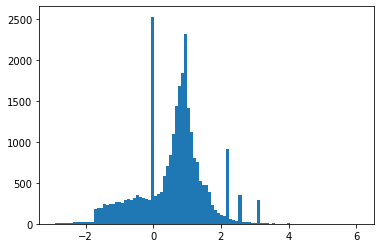

In [12]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

To keep this tutorial relatively short, use just the first 1,000 samples for validation, and the next 10,000 for training:

In [13]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

The `Dataset.skip` and `Dataset.take` methods make this easy.

At the same time, use the `Dataset.cache` method to ensure that the loader doesn't need to re-read the data from the file on each epoch:

In [14]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [15]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

These datasets return individual examples. Use the `Dataset.batch` method to create batches of an appropriate size for training. Before batching, also remember to use `Dataset.shuffle` and `Dataset.repeat` on the training set.

In [16]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## Demonstrate overfitting

The simplest way to prevent overfitting is to start with a small model: A model with a small number of learnable parameters (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".

Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.

Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). You will have to experiment using a series of different architectures.

To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.

Start with a simple model using only densely-connected layers (`tf.keras.layers.Dense`) as a baseline, then create larger models, and compare them.

### Training procedure

Many models train better if you gradually reduce the learning rate during training. Use `tf.keras.optimizers.schedules` to reduce the learning rate over time:

In [17]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

The code above sets a `tf.keras.optimizers.schedules.InverseTimeDecay` to hyperbolically decrease the learning rate to 1/2 of the base rate at 1,000 epochs, 1/3 at 2,000 epochs, and so on.

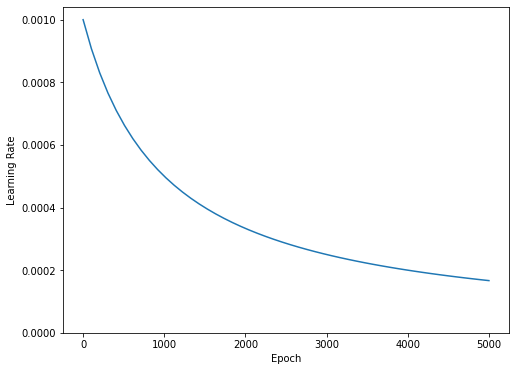

In [18]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


Each model in this tutorial will use the same training configuration. So set these up in a reusable way, starting with the list of callbacks.

The training for this tutorial runs for many short epochs. To reduce the logging noise use the `tfdocs.EpochDots` which simply prints a `.` for each epoch, and a full set of metrics every 100 epochs.

Next include `tf.keras.callbacks.EarlyStopping` to avoid long and unnecessary training times. Note that this callback is set to monitor the `val_binary_crossentropy`, not the `val_loss`. This difference will be important later.

Use `callbacks.TensorBoard` to generate TensorBoard logs for the training.


In [19]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

Similarly each model will use the same `Model.compile` and `Model.fit` settings:

In [20]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### Tiny model

Start by training a model:

In [21]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [22]:
size_histories = {}

In [23]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 16)                464       


 dense_1 (Dense)             (None, 1)                 17        


Total params: 481


Trainable params: 481


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.4915,  binary_crossentropy:0.8589,  loss:0.8589,  val_accuracy:0.4730,  val_binary_crossentropy:0.8619,  val_loss:0.8619,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.5950,  binary_crossentropy:0.6277,  loss:0.6277,  val_accuracy:0.5760,  val_binary_crossentropy:0.6304,  val_loss:0.6304,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6234,  binary_crossentropy:0.6136,  loss:0.6136,  val_accuracy:0.6030,  val_binary_crossentropy:0.6139,  val_loss:0.6139,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6392,  binary_crossentropy:0.6036,  loss:0.6036,  val_accuracy:0.6410,  val_binary_crossentropy:0.5996,  val_loss:0.5996,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6538,  binary_crossentropy:0.5959,  loss:0.5959,  val_accuracy:0.6310,  val_binary_crossentropy:0.5926,  val_loss:0.5926,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6628,  binary_crossentropy:0.5914,  loss:0.5914,  val_accuracy:0.6480,  val_binary_crossentropy:0.5891,  val_loss:0.5891,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6636,  binary_crossentropy:0.5882,  loss:0.5882,  val_accuracy:0.6620,  val_binary_crossentropy:0.5870,  val_loss:0.5870,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6706,  binary_crossentropy:0.5857,  loss:0.5857,  val_accuracy:0.6530,  val_binary_crossentropy:0.5877,  val_loss:0.5877,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 800, accuracy:0.6667,  binary_crossentropy:0.5838,  loss:0.5838,  val_accuracy:0.6700,  val_binary_crossentropy:0.5865,  val_loss:0.5865,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 900, accuracy:0.6710,  binary_crossentropy:0.5820,  loss:0.5820,  val_accuracy:0.6590,  val_binary_crossentropy:0.5874,  val_loss:0.5874,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1000, accuracy:0.6772,  binary_crossentropy:0.5803,  loss:0.5803,  val_accuracy:0.6690,  val_binary_crossentropy:0.5857,  val_loss:0.5857,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1100, accuracy:0.6775,  binary_crossentropy:0.5791,  loss:0.5791,  val_accuracy:0.6670,  val_binary_crossentropy:0.5860,  val_loss:0.5860,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1200, accuracy:0.6799,  binary_crossentropy:0.5784,  loss:0.5784,  val_accuracy:0.6670,  val_binary_crossentropy:0.5852,  val_loss:0.5852,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1300, accuracy:0.6851,  binary_crossentropy:0.5767,  loss:0.5767,  val_accuracy:0.6560,  val_binary_crossentropy:0.5872,  val_loss:0.5872,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1400, accuracy:0.6759,  binary_crossentropy:0.5758,  loss:0.5758,  val_accuracy:0.6760,  val_binary_crossentropy:0.5829,  val_loss:0.5829,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1500, accuracy:0.6780,  binary_crossentropy:0.5746,  loss:0.5746,  val_accuracy:0.6650,  val_binary_crossentropy:0.5827,  val_loss:0.5827,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1600, accuracy:0.6790,  binary_crossentropy:0.5740,  loss:0.5740,  val_accuracy:0.6700,  val_binary_crossentropy:0.5822,  val_loss:0.5822,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1700, accuracy:0.6826,  binary_crossentropy:0.5733,  loss:0.5733,  val_accuracy:0.6620,  val_binary_crossentropy:0.5826,  val_loss:0.5826,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1800, accuracy:0.6821,  binary_crossentropy:0.5726,  loss:0.5726,  val_accuracy:0.6500,  val_binary_crossentropy:0.5851,  val_loss:0.5851,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1900, accuracy:0.6810,  binary_crossentropy:0.5722,  loss:0.5722,  val_accuracy:0.6700,  val_binary_crossentropy:0.5818,  val_loss:0.5818,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

Now check how the model did:

(0.5, 0.7)

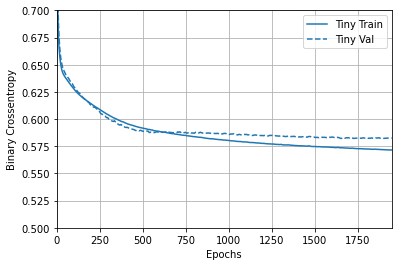

In [24]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

### Small model

To check if you can beat the performance of the small model, progressively train some larger models.

Try two hidden layers with 16 units each:

In [25]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [26]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_2 (Dense)             (None, 16)                464       


 dense_3 (Dense)             (None, 16)                272       


 dense_4 (Dense)             (None, 1)                 17        


Total params: 753


Trainable params: 753


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.4831,  binary_crossentropy:0.7411,  loss:0.7411,  val_accuracy:0.4670,  val_binary_crossentropy:0.7131,  val_loss:0.7131,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6186,  binary_crossentropy:0.6162,  loss:0.6162,  val_accuracy:0.5950,  val_binary_crossentropy:0.6131,  val_loss:0.6131,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6642,  binary_crossentropy:0.5920,  loss:0.5920,  val_accuracy:0.6570,  val_binary_crossentropy:0.5967,  val_loss:0.5967,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6737,  binary_crossentropy:0.5823,  loss:0.5823,  val_accuracy:0.6210,  val_binary_crossentropy:0.5981,  val_loss:0.5981,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6779,  binary_crossentropy:0.5735,  loss:0.5735,  val_accuracy:0.6500,  val_binary_crossentropy:0.5905,  val_loss:0.5905,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6872,  binary_crossentropy:0.5688,  loss:0.5688,  val_accuracy:0.6500,  val_binary_crossentropy:0.5887,  val_loss:0.5887,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6888,  binary_crossentropy:0.5645,  loss:0.5645,  val_accuracy:0.6560,  val_binary_crossentropy:0.5897,  val_loss:0.5897,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### Medium model

Now try three hidden layers with 64 units each:

In [27]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

And train the model using the same data:

In [28]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_5 (Dense)             (None, 64)                1856      


 dense_6 (Dense)             (None, 64)                4160      


 dense_7 (Dense)             (None, 64)                4160      


 dense_8 (Dense)             (None, 1)                 65        


Total params: 10,241


Trainable params: 10,241


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.4828,  binary_crossentropy:0.7027,  loss:0.7027,  val_accuracy:0.5230,  val_binary_crossentropy:0.6887,  val_loss:0.6887,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.7235,  binary_crossentropy:0.5269,  loss:0.5269,  val_accuracy:0.6650,  val_binary_crossentropy:0.5993,  val_loss:0.5993,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.7851,  binary_crossentropy:0.4316,  loss:0.4316,  val_accuracy:0.6470,  val_binary_crossentropy:0.7039,  val_loss:0.7039,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### Large model

As an exercise, you can create an even larger model and check how quickly it begins overfitting. Next, add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [29]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

And, again, train the model using the same data:

In [30]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_9 (Dense)             (None, 512)               14848     


 dense_10 (Dense)            (None, 512)               262656    


 dense_11 (Dense)            (None, 512)               262656    


 dense_12 (Dense)            (None, 512)               262656    


 dense_13 (Dense)            (None, 1)                 513       


Total params: 803,329


Trainable params: 803,329


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.5092,  binary_crossentropy:0.8567,  loss:0.8567,  val_accuracy:0.5720,  val_binary_crossentropy:0.6973,  val_loss:0.6973,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0028,  loss:0.0028,  val_accuracy:0.6510,  val_binary_crossentropy:1.7349,  val_loss:1.7349,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0002,  loss:0.0002,  val_accuracy:0.6480,  val_binary_crossentropy:2.4393,  val_loss:2.4393,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### Plot the training and validation losses

The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model).

While building a larger model gives it more power, if this power is not constrained somehow it can easily overfit to the training set.

In this example, typically, only the `"Tiny"` model manages to avoid overfitting altogether, and each of the larger models overfit the data more quickly. This becomes so severe for the `"large"` model that you need to switch the plot to a log-scale to really figure out what's happening.

This is apparent if you plot and compare the validation metrics to the training metrics.

* It's normal for there to be a small difference.
* If both metrics are moving in the same direction, everything is fine.
* If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
* If the validation metric is going in the wrong direction, the model is clearly overfitting.

Text(0.5, 0, 'Epochs [Log Scale]')

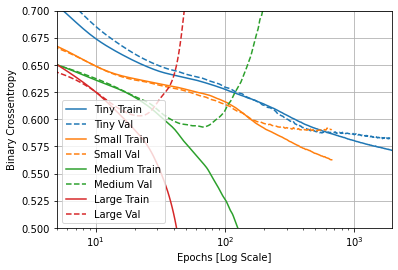

In [31]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

Note: All the above training runs used the `callbacks.EarlyStopping` to end the training once it was clear the model was not making progress.

### View in TensorBoard

These models all wrote TensorBoard logs during training.

Open an embedded  TensorBoard viewer inside a notebook:

In [ ]:
#docs_infra: no_execute

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

You can view the [results of a previous run](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It's also included in an `<iframe>` for convenience:

In [32]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

If you want to share TensorBoard results you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This step requires a Google account.

```
!tensorboard dev upload --logdir  {logdir}/sizes
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

## Strategies to prevent overfitting

Before getting into the content of this section copy the training logs from the `"Tiny"` model above, to use as a baseline for comparison.

In [33]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmpfs/tmp/tmp94hlpmkm/tensorboard_logs/regularizers/Tiny')

In [34]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### Add weight regularization


You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as demonstrated in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

* [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization), where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

* [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization), where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero, encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights—one reason why L2 is more common.

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Add L2 weight regularization:

In [35]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_14 (Dense)            (None, 512)               14848     


 dense_15 (Dense)            (None, 512)               262656    


 dense_16 (Dense)            (None, 512)               262656    


 dense_17 (Dense)            (None, 512)               262656    


 dense_18 (Dense)            (None, 1)                 513       


Total params: 803,329


Trainable params: 803,329


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.5052,  binary_crossentropy:0.8148,  loss:2.3360,  val_accuracy:0.4760,  val_binary_crossentropy:0.6928,  val_loss:2.1343,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6674,  binary_crossentropy:0.5924,  loss:0.6171,  val_accuracy:0.6470,  val_binary_crossentropy:0.5829,  val_loss:0.6077,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6727,  binary_crossentropy:0.5824,  loss:0.6064,  val_accuracy:0.6830,  val_binary_crossentropy:0.5901,  val_loss:0.6145,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6828,  binary_crossentropy:0.5753,  loss:0.5982,  val_accuracy:0.6700,  val_binary_crossentropy:0.5787,  val_loss:0.6017,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6908,  binary_crossentropy:0.5680,  loss:0.5931,  val_accuracy:0.6810,  val_binary_crossentropy:0.5801,  val_loss:0.6052,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value**2` to the total **loss** of the network.

That is why we're monitoring the `binary_crossentropy` directly. Because it doesn't have this regularization component mixed in.

So, that same `"Large"` model with an `L2` regularization penalty performs much better:


(0.5, 0.7)

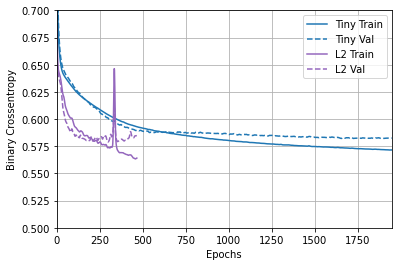

In [36]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

As demonstrated in the diagram above, the `"L2"` regularized model is now much more competitive with the `"Tiny"` model. This `"L2"` model is also much more resistant to overfitting than the `"Large"` model it was based on despite having the same number of parameters.

#### More info

There are two important things to note about this sort of regularization:

1. If you are writing your own training loop, then you need to be sure to ask the model for its regularization losses.

In [37]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

2. This implementation works by adding the weight penalties to the model's loss, and then applying a standard optimization procedure after that.

There is a second approach that instead only runs the optimizer on the raw loss, and then while applying the calculated step the optimizer also applies some weight decay. This "decoupled weight decay" is used in optimizers like `tf.keras.optimizers.Ftrl` and `tfa.optimizers.AdamW`.

### Add dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. For example, a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. `[0, 0.5, 1.3, 0, 1.1]`.

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In Keras, you can introduce dropout in a network via the `tf.keras.layers.Dropout` layer, which gets applied to the output of layer right before.

Add two dropout layers to your network to check how well they do at reducing overfitting:

In [38]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_19 (Dense)            (None, 512)               14848     


 dropout (Dropout)           (None, 512)               0         


 dense_20 (Dense)            (None, 512)               262656    


 dropout_1 (Dropout)         (None, 512)               0         


 dense_21 (Dense)            (None, 512)               262656    


 dropout_2 (Dropout)         (None, 512)               0         


 dense_22 (Dense)            (None, 512)               262656    


 dropout_3 (Dropout)         (None, 512)               0         


 dense_23 (Dense)            (None, 1)                 513       


Total params: 803,329


Trainable params: 803,329


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.5034,  binary_crossentropy:0.8014,  loss:0.8014,  val_accuracy:0.5600,  val_binary_crossentropy:0.7065,  val_loss:0.7065,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6590,  binary_crossentropy:0.5918,  loss:0.5918,  val_accuracy:0.6780,  val_binary_crossentropy:0.5788,  val_loss:0.5788,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6848,  binary_crossentropy:0.5603,  loss:0.5603,  val_accuracy:0.6800,  val_binary_crossentropy:0.5828,  val_loss:0.5828,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.7265,  binary_crossentropy:0.5084,  loss:0.5084,  val_accuracy:0.6960,  val_binary_crossentropy:0.5910,  val_loss:0.5910,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

(0.5, 0.7)

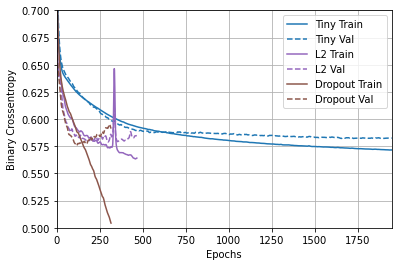

In [39]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

It's clear from this plot that both of these regularization approaches improve the behavior of the `"Large"` model. But this still doesn't beat even the `"Tiny"` baseline.

Next try them both, together, and see if that does better.

### Combined L2 + dropout

In [40]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_24 (Dense)            (None, 512)               14848     


 dropout_4 (Dropout)         (None, 512)               0         


 dense_25 (Dense)            (None, 512)               262656    


 dropout_5 (Dropout)         (None, 512)               0         


 dense_26 (Dense)            (None, 512)               262656    


 dropout_6 (Dropout)         (None, 512)               0         


 dense_27 (Dense)            (None, 512)               262656    


 dropout_7 (Dropout)         (None, 512)               0         


 dense_28 (Dense)            (None, 1)                 513       


Total params: 803,329


Trainable params: 803,329


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.5102,  binary_crossentropy:0.7920,  loss:0.9501,  val_accuracy:0.5270,  val_binary_crossentropy:0.6840,  val_loss:0.8413,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6524,  binary_crossentropy:0.6050,  loss:0.6335,  val_accuracy:0.6080,  val_binary_crossentropy:0.5926,  val_loss:0.6209,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6595,  binary_crossentropy:0.5944,  loss:0.6192,  val_accuracy:0.6860,  val_binary_crossentropy:0.5837,  val_loss:0.6084,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6682,  binary_crossentropy:0.5839,  loss:0.6118,  val_accuracy:0.6880,  val_binary_crossentropy:0.5692,  val_loss:0.5972,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6794,  binary_crossentropy:0.5744,  loss:0.6042,  val_accuracy:0.6850,  val_binary_crossentropy:0.5597,  val_loss:0.5896,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6752,  binary_crossentropy:0.5727,  loss:0.6051,  val_accuracy:0.6910,  val_binary_crossentropy:0.5516,  val_loss:0.5839,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6876,  binary_crossentropy:0.5646,  loss:0.5991,  val_accuracy:0.7020,  val_binary_crossentropy:0.5532,  val_loss:0.5876,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6896,  binary_crossentropy:0.5596,  loss:0.5954,  val_accuracy:0.6860,  val_binary_crossentropy:0.5490,  val_loss:0.5849,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 800, accuracy:0.6933,  binary_crossentropy:0.5591,  loss:0.5966,  val_accuracy:0.6940,  val_binary_crossentropy:0.5461,  val_loss:0.5837,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 900, accuracy:0.6942,  binary_crossentropy:0.5539,  loss:0.5925,  val_accuracy:0.6990,  val_binary_crossentropy:0.5497,  val_loss:0.5883,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

(0.5, 0.7)

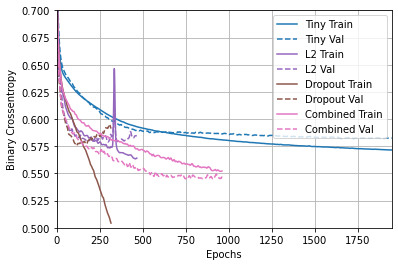

In [41]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

This model with the `"Combined"` regularization is obviously the best one so far.

### View in TensorBoard

These models also recorded TensorBoard logs.

To open an embedded  tensorboard viewer inside a notebook, copy the following into a code-cell:

```
%tensorboard --logdir {logdir}/regularizers
```

You can view the [results of a previous run](https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

It's also included in an `<iframe>` for convenience:

In [42]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")


This was uploaded with:

```
!tensorboard dev upload --logdir  {logdir}/regularizers
```

## Conclusions

To recap, here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Two important approaches not covered in this guide are:

* [Data augmentation](../images/data_augmentation.ipynb)
* Batch normalization (`tf.keras.layers.BatchNormalization`)

Remember that each method can help on its own, but often combining them can be even more effective.